In [1]:
import os  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from sklearn.preprocessing import LabelEncoder  
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  

In [4]:
base_path = r"C:\Users\fmantecam\OneDrive - UNICAN\RamanNanoBase\FITOPLANCTON_ESPECIES_UAM\df_filtrados"

file_names = [
    "RAW_CyanobacteriaSpecies_RamanSpectra_UNSEENS.csv",
    "especiesUAM_UNSEENS_BASELINES_normSPECTRUM_SNR30_V171124_FILTRADOPLASTICO2percent_withCOORDINATES_WITHOUTOUTLIERS_percentile_281124.csv",
    "especiesUAM_UNSEENS_CORRECTED_normSPECTRUM_SNR30_V171124_FILTRADOPLASTICO2percent_withCOORDINATES_WITHOUTOUTLIERS_percentile_281124.csv"
]


datasets = [pd.read_csv(os.path.join(base_path, file)) for file in file_names]

# Define colors using the tab20 colormap from Matplotlib
colormap = plt.cm.tab20
colors = colormap.colors  # Extract the list of colors from the colormap

# Ensure a specific order of classes in the LabelEncoder
ordered_classes = ['UAM502', 'UAM588', 'UAM565', 'UAM253']
le = LabelEncoder()
le.classes_ = np.array(ordered_classes)  # Assign the desired order of classes

label = 'especie'  # Name of the column containing the labels

# Create lists to store labels and encoded data
labels_list = []
y_encoded_list = []

label = 'especie'  # Name of the column containing the labels

# Loop over each dataset to extract the 'especie' labels and encode them
for df in datasets:
    df_filtered = df[df[label] != 'charco']
    labels = df[label].values  # Get 'especie' labels as a numpy array
    y_encoded = le.transform(labels)  # Encode 'especie' labels using the defined order
    labels_list.append(labels)  # Store the original labels
    y_encoded_list.append(y_encoded)  # Store the encoded labels

# List of headers corresponding to each dataset (same as file_names in this case)
headers = file_names


In [38]:
def process_and_plot_lda(datasets, file_names, ordered_classes=None, label='especie'):
    """
    Applies Linear Discriminant Analysis (LDA) to multiple datasets and plots the results in a 1x3 subplot format.

    Args:
        datasets (list of DataFrame): List of datasets to process with LDA.
        file_names (list of str): List of file names corresponding to the datasets for labeling and reference.
        ordered_classes (list of str, optional): Desired order of class labels for encoding. If None, the class order in the dataset is used.
        label (str, optional): Name of the column containing the labels for classification. Default is 'especie'.

    Returns:
        None
    """
    # Define the colormap using Matplotlib's tab20
    colormap = plt.cm.tab20
    colors = colormap.colors  # Extract the list of colors from the colormap

    # Create a figure with 1x3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
    axes = axes.flatten()  # Flatten axes to simplify iteration

    titles = ['Raw spectra', 'Baseline corrections', 'Preprocessed spectra']

    # Iterate over datasets to process them
    for i, (df, ax) in enumerate(zip(datasets, axes)):
        print(f"Processing LDA for: {file_names[i]}")

        # Check if the label column exists in the dataset
        if label not in df.columns:
            print(f"Warning: '{label}' not found in {file_names[i]}")
            ax.set_title(f"{file_names[i]} (No Data)")
            ax.axis('off')
            continue

        # Extract the labels
        y = df[label].values
        unique_classes_in_dataset = np.unique(y)

        # Check if the dataset classes match `ordered_classes`
        if ordered_classes and set(unique_classes_in_dataset).issubset(set(ordered_classes)):
            # Use `ordered_classes` if they match
            le = LabelEncoder()
            le.classes_ = np.array(ordered_classes)
            y_encoded = le.transform(y)
        else:
            # Skip `ordered_classes` and use the dataset's classes
            le = LabelEncoder()
            y_encoded = le.fit_transform(y)

        # Remove irrelevant columns that shouldn't be used for LDA
        columns_to_drop = ['X', 'Y', 'name', 't_exp', 'date', 'medium', 'especie']
        columns_to_drop = [col for col in columns_to_drop if col in df.columns]  # Ensure columns exist before dropping
        X = df.drop(columns=columns_to_drop, axis=1)

        # Filter numerical columns
        X = X.select_dtypes(include=[np.number])
        letters = ['(a)', '(b)', '(c)']
        # Verify there are enough numerical features
        if X.shape[1] < 2:
            print(f"Warning: Not enough numerical features in {file_names[i]} for LDA.")
            ax.set_title(f"{file_names[i]} (Insufficient Data)")
            ax.axis('off')
            continue

        # Check the number of classes
        n_classes = len(np.unique(y_encoded))
        n_features = X.shape[1]
        max_components = min(n_features, n_classes - 1)

        if max_components < 2:
            print(f"Warning: Cannot compute 2 LDA components for {file_names[i]}. Only {max_components} component(s) can be computed.")
            ax.set_title(f"{file_names[i]} (Insufficient Classes)")
            ax.axis('off')
            continue

        # Apply LDA with two components
        lda = LinearDiscriminantAnalysis(n_components=2)
        X_lda = lda.fit_transform(X, y_encoded)

        # Plot the first two LDA components on the corresponding subplot
        unique_labels = np.unique(y_encoded)
        for j, label_value in enumerate(unique_labels):
            actual_label = le.inverse_transform([label_value])[0]
            X_label = X_lda[y_encoded == label_value]
            ax.scatter(X_label[:, 0], X_label[:, 1], label=actual_label, color=colors[j % len(colors)])

        # Configure the subplot
        ax.set_xlabel('LDA Component 1', fontsize=14, labelpad=10)
        ax.set_ylabel('LDA Component 2', fontsize=14, labelpad=5)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_title(f'{titles[i]}', fontsize=15)
        ax.text(0.924, 0.975, letters[i], transform=ax.transAxes, fontsize=16.5, verticalalignment='top')
        ax.legend(loc='upper left', fontsize=11)
        ax.grid(alpha=0.4)

    # Adjust layout for all subplots
    plt.tight_layout()
    # fig.savefig('C:\\Users\\fmantecam\\OneDrive - UNICAN\\Figuraspapercianos\\figS4_LDA.svg', format='svg', bbox_inches='tight')
    # fig.savefig('C:\\Users\\fmantecam\\OneDrive - UNICAN\\Figuraspapercianos\\figS4_LDA.png', format='png', bbox_inches='tight')
    plt.show()


Processing LDA for: RAW_CyanobacteriaSpecies_RamanSpectra_UNSEENS.csv
Processing LDA for: especiesUAM_UNSEENS_BASELINES_normSPECTRUM_SNR30_V171124_FILTRADOPLASTICO2percent_withCOORDINATES_WITHOUTOUTLIERS_percentile_281124.csv
Processing LDA for: especiesUAM_UNSEENS_CORRECTED_normSPECTRUM_SNR30_V171124_FILTRADOPLASTICO2percent_withCOORDINATES_WITHOUTOUTLIERS_percentile_281124.csv


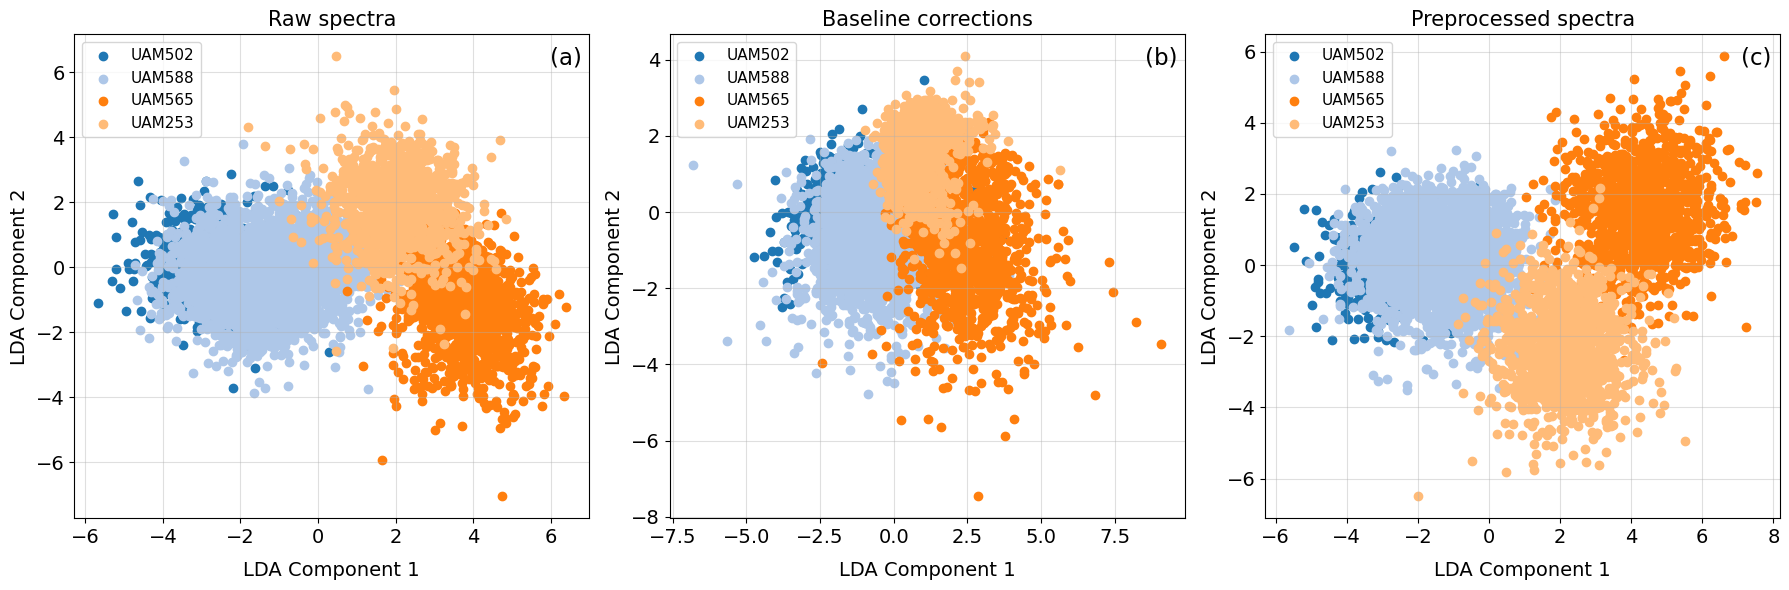

In [39]:
process_and_plot_lda(datasets, file_names, ordered_classes)